<a href="https://colab.research.google.com/github/satishchaudhary382/algorithmic-trading-with-python/blob/master/Final%20Chart%20version%2022.05.2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [500]:
# !pip install finta
# !pip install pandas_ta
# !pip install MarketProfile
# !pip install -U git+https://github.com/twopirllc/pandas-ta
# !pip install numpy --upgrade
# !pip install mplfinance

In [501]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import pandas_ta as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from finta import TA
from sklearn.preprocessing import MinMaxScaler


In [502]:
stock = "de"
df = pdr.get_data_yahoo(f"{stock}","1-1-2020")

In [503]:
#@title TRIMA band
def trima(df):
  df['trima'] = ta.trima(df['Close'],21)
  df['range'] = ta.atr(df.High, df.Low, df.Close, 14) * 4
  df['H'] = ta.wma((df['trima'] + df['range']),21)
  df['L'] = ta.wma((df['trima'] - df['range']),21)
  df['SD_UP'] = df['H'].rolling(20).std()
  # df['SD_DOWN'] = ((df['trima'] - df['range'])).rolling(20).std()
  df['HH'] = ta.wma((df['trima'] + df['range']),21)+(ta.atr(df.High, df.Low, df.Close,21))*1
  df['LL'] = ta.wma((df['trima'] - df['range']),21)-(ta.atr(df.High, df.Low, df.Close,21))*1
  return df[['HH','H','LL','L']]

In [504]:
#@title SHA

def SHA(df, length):
  import warnings
  warnings.filterwarnings("ignore")
  
  import matplotlib.pyplot as plt
  from bokeh.plotting import figure, output_file, show
  import bokeh
  from math import pi
  from bokeh.io import output_notebook
  from bokeh.models import Label
  from datetime import datetime as dt
  # Call once to configure Bokeh to display plots inline in the notebook.
  output_notebook()
  %matplotlib inline
  from math import pi
  from bokeh.models import Span
  w_l = length
  df['O'],df['H'],df['L'],df['C']= ta.ema(df['Open'], w_l),ta.ema(df['High'], w_l),ta.ema(df['Low'], w_l),ta.ema(df['Close'], w_l)
  df = df.dropna()
  df['C_1'] = (df['O']+df['H']+df['L']+df['O'])/4
  O,C = [df['O'][0]],[df['C'][0]]
  o,c = df['O'].shift(-1),df['C'].shift(-1)
  t= (o+c)/2
  r = t.shift(1)
  r[np.isnan(r)]=df['O'][0]
  df['O_1'] = t
  df['H_1'] = df[['H','O_1']].max(axis=1)
  df['L_1'] = df[['L','O_1']].min(axis=1)
  df['O_2'] = ta.ema(df['O_1'],w_l)
  df['L_2'] = ta.ema(df['L_1'],w_l)
  df['H_2'] = ta.ema(df['H_1'],w_l)
  df['C_2'] = ta.ema(df['C_1'],w_l)
  df['C_2'][-1] = df.C_1[-1]
  # df = df.dropna()
# df = df[['O_2','H_2','L_2','C_2','Volume']]
  df = df.reset_index()
  return df[['Date','Open','High','Low','Close','O_2','H_2','L_2','C_2']]

In [505]:
#@title MArket Profile
from market_profile import MarketProfile

df = pdr.get_data_yahoo(f'{stock}',"12-1-2020")

class Analysis:
  
  def __init__(self, dataframe):
    self.dataframe = dataframe
    self.profile = []
    self.levels = []
    self.level = []

  # Diagram for candle stick 
  def candlestick(self):
    return self.dataframe

  # Calculation of Market Profile
  def market_profile(self):
    for i in range(1,len(self.dataframe),20):
      try:
        mp = MarketProfile(self.dataframe)
        mp_slice = mp[self.dataframe.index[0+i]: self.dataframe.index[20+i]]
        self.profile.append(mp_slice.poc_price)
      except:
        pass
    return self.profile


a = Analysis(df)


b = a.market_profile()

In [506]:
# Load Data 
df = pdr.get_data_yahoo(f'{stock}',"12-1-2020")

# Heikin ashi 1
h1 = df.copy(deep = True)
ha1 = SHA(h1,5)
# Heikin ashi 2
h2 = df.copy(deep = True)
ha2 = SHA(h2,7)

# Squeeze
s = df.copy(deep = True)
s['low'] = ta.squeeze(df['High'],df['Low'], df['Close'],20,2,20,1)['SQZ_ON']
s['med'] = ta.squeeze(df['High'],df['Low'], df['Close'],20,1.6,20,1)['SQZ_ON']
s['high'] = ta.squeeze(df['High'],df['Low'], df['Close'],20,1,20,1)['SQZ_ON']

s['low_h'] = s.apply(lambda x: x['High']+6 if x['low']!=0 else np.nan, axis = 1)
s['low_l'] = s.apply(lambda x: x['Low']-6 if x['low']!=0 else np.nan, axis =1 )
s['med_h'] = s.apply(lambda x: x['High']+10 if x['med']!=0 else np.nan, axis = 1)
s['med_l'] = s.apply(lambda x: x['Low']-10 if x['med']!=0 else np.nan, axis =1 )
s['high_h'] = s.apply(lambda x: x['High']+14 if x['high']!=0 else np.nan, axis = 1)
s['high_l'] = s.apply(lambda x: x['Low']-14 if x['high']!=0 else np.nan, axis =1 )

# Even better sine wave
ebsw = df.copy(deep = True)
ebsw['ebsw'] = ta.ssf(ta.ebsw(df['Close']).fillna(method = 'bfill'))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(ha1['C_2'].min(), ha1['C_2'].max()))
ebsw['final'] =  scaler.fit_transform(ebsw['ebsw'].values.reshape(-1, 1))

# TRIMA
tma = df.copy(deep = True)
dfs = trima(tma)

# WTO
o = df.copy(deep = True)
o['WT1'] = TA.WTO(df)['WT1.'].fillna(method = 'bfill')
o['WT2'] = TA.WTO(df)['WT2.'].fillna(method = 'bfill')

# Bear and Bull
bb = df.copy(deep = True)
bb['EFI'] = TA.EFI(bb)
bb['EFI1'] = TA.EFI(bb,14)
bb['EFI2'] = TA.EFI(bb,20)
bb['m'] = (bb['EFI']+bb['EFI1']+bb['EFI2'])/3
bb['colorm'] = np.where(bb['m']<0, 'red','green')

In [507]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
               vertical_spacing=0.02, 
               row_width=[0.4,0.4,0.4,0.7]) # subplot_titles=(f'{stock}') if want to add title

# Candle stick chart
fig.add_trace(go.Candlestick(x=df.index,open=df['Open'],high=df['High'],low=df['Low'],close=df['Close'], 
                             name = 'Candlestick',increasing_line_color= '#000000', decreasing_line_color= '#000000',
                             decreasing_fillcolor = "#FFFFFF", increasing_fillcolor = "#000000", 
                             increasing_line_width=1,decreasing_line_width=1), row=1, col=1)

#Heikin ashi chart 1
fig.add_trace(go.Candlestick(x=ha1['Date'],open=ha1['O_2'],high=ha1['C_2'],low=ha1['O_2'],close=ha1['C_2'], 
                             name = 'Trend Filter1',increasing_line_color= '#FF0000', decreasing_line_color= '#0D600D',
                             decreasing_fillcolor = "#0D600D", increasing_fillcolor = "#FF0000", 
                             increasing_line_width=2,decreasing_line_width=2), row=2,col=1)

#Heikin ashi chart 2
fig.add_trace(go.Candlestick(x=ha2['Date'],open=ha2['O_2'],high=ha2['C_2'],low=ha2['O_2'],close=ha2['C_2'], 
                             name = 'Trend Filter2',increasing_line_color= '#FF0000', decreasing_line_color= '#0D600D',
                             decreasing_fillcolor = "#0D600D", increasing_fillcolor = "#FF0000", 
                             increasing_line_width=2,decreasing_line_width=2), row=2,col=1)
fig.add_trace(go.Scatter(x = ebsw.index, y = ebsw['final'] ,mode = 'lines', line_color='black',line=dict(color='black',width=1), 
                         opacity = 0.4, name = 'Cycle'), row=2, col=1)

# Squeeze 
fig.add_trace(go.Scatter(x=s.index, y=s.low_h,mode='markers', marker_size = 3,marker_color = '#42f5e6'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.low_l,mode='markers', marker_size = 3,marker_color = '#42f5e6'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.med_h,mode='markers', marker_size = 4,marker_color = '#f542e3'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.med_l,mode='markers', marker_size = 4,marker_color = '#f542e3'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.high_h,mode='markers', marker_size = 5,marker_color = '#f70a0a'), row=1, col=1)
fig.add_trace(go.Scatter(x=s.index, y=s.high_l,mode='markers', marker_size = 5,marker_color = '#f70a0a'), row=1, col=1)

#Volume Profile 
# SR Volume Profile
for line in b:
  fig.add_trace(go.Scatter(x = df.index, y = pd.Series(np.array([line for _ in range(len(df))])), mode = 'lines', line = dict(color = "red", width = 1), name = "VP S/R"))

#TRIMA
# Upper and Lower Resistance
fig.add_trace(go.Scatter(x=dfs.index, y=dfs.HH,fill=None, mode='lines',line_color='green',line=dict(color='green',width=1),opacity=0.3, name = "Upper Resistance 1"),row=1,col=1)
fig.add_trace(go.Scatter(x=dfs.index, y=dfs.H,fill='tonexty',mode='lines', line_color='green',line=dict(color='green',width=1),opacity=0.3,name = "Upper Resistance 2"),row=1,col=1)   
fig.add_trace(go.Scatter(x=dfs.index, y=dfs.LL,fill=None, mode='lines',line_color='red',line=dict(color='red',width=1), name = "Lower Support 1"),row=1,col=1)
fig.add_trace(go.Scatter(x=dfs.index, y=dfs.L,fill='tonexty',mode='lines', line_color='red',line=dict(color='red',width=1), name = "Lower Support 2"),row=1,col=1)

#OverBought and OverSold
#Over Bought and Over Sold along with Mass Index
fig.add_trace(go.Scatter(x = o.index, y = ta.ssf(o['WT1']),fill =None, mode = 'lines',line_color='green',line=dict(color='green',width=1),name='WT1'), row = 3, col = 1)
fig.add_trace(go.Scatter(x = o.index, y = ta.ssf(o['WT2']), mode = 'lines',line_color='red',line=dict(color='red',width=1),name='WT2'), row = 3, col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([0 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([53 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([60 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([-53 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)
fig.add_trace(go.Scatter(x = o.index, y = pd.Series(np.array([-60 for _ in range(len(o))])), mode = 'lines', line = dict(color = 'black', width =1, dash = 'dot'), name = 'Zero Line'), row = 3,col = 1)

#Bear and Bull volume
fig.add_trace(go.Bar(name='Bull and Bear',x=bb.index,y=bb.m,marker_color=bb['colorm']), row= 4, col = 1)

fig.update_layout(xaxis_rangeslider_visible=False,showlegend = False,barmode='stack',height=1000) #xaxis_title="Date"
fig.update_xaxes(rangeslider= {'visible':False}, row=1, col=1)
fig.update_xaxes(rangeslider= {'visible':False}, row=2, col=1)
fig.update_xaxes(showgrid=True,gridwidth=1, gridcolor='gray')
# fig.update_yaxes(showgrid=False, gridwidth=1, gridcolor='gray')
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)'})

fig.show()

In [508]:
import mplfinance as mplt

In [509]:
ha1 = ha1[['Date','O_2',"H_2","L_2","C_2"]]
ha1.columns = ['Date','Open','High','Low','Close']
ha2 = ha2[['Date','O_2',"H_2","L_2","C_2"]]
ha2.columns = ['Date','Open','High','Low','Close']

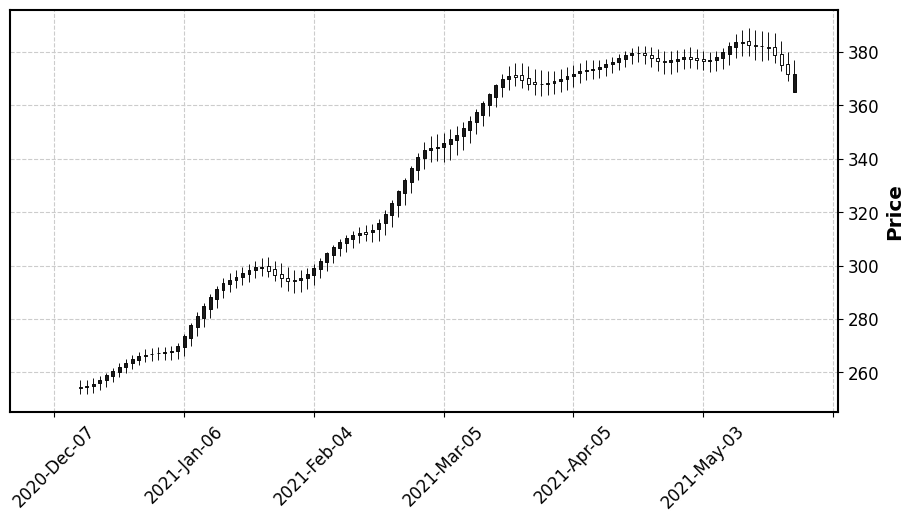

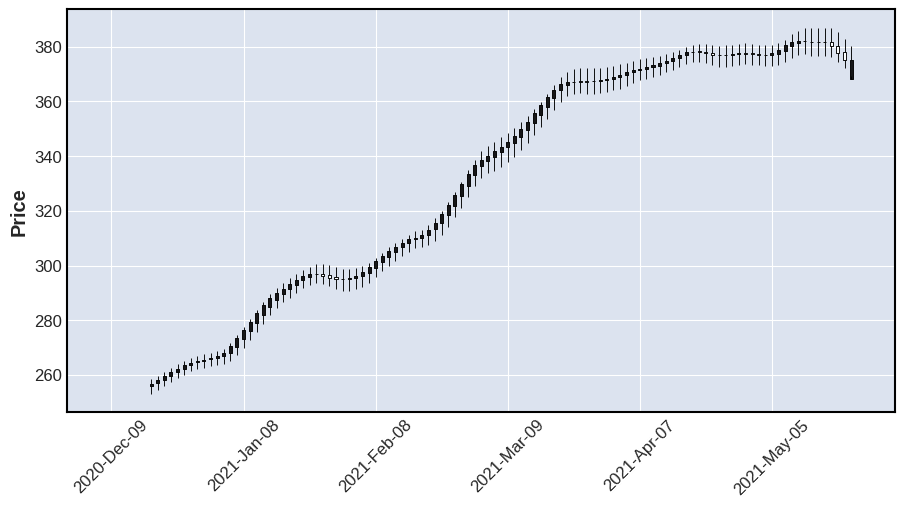

In [512]:
mplt.plot(ha1.set_index("Date"), type = 'candle',style = 'classic',figratio = (20,10))
mplt.plot(ha2.set_index("Date"), type = 'candle',figratio = (20,10))

In [511]:
ha1

,Date,Open,High,Low,Close
0,2020-12-07,NaN,NaN,NaN,NaN
1,2020-12-08,NaN,NaN,NaN,NaN
2,2020-12-09,NaN,NaN,NaN,NaN
3,2020-12-10,NaN,NaN,NaN,NaN
4,2020-12-11,254.284591,257.095235,252.091564,254.732941
...,...,...,...,...,...
110,2021-05-17,381.500816,387.346436,376.930042,382.001431
111,2021-05-18,378.866395,387.029610,375.819213,381.843355
112,2021-05-19,375.219276,384.127729,372.807608,379.258281
113,2021-05-20,371.771191,380.046035,368.993827,375.564273
